##### top

# Simulate potential span and range of reliabilities estimated using attenuation correction across days

This ntb looks at synthetic data vs real data to estimate the range of possible reliabilities that we could observe by chance if we use attenuation correction on two separate days. The idea is to check the effect of possible outliers that drove this reliability to be more than one in the original dataset.

Specifically this is looking at longitudinal FMP data and 2 days comparison in the battery.


* [Load and clean data](#Load-and-clean-data)

In [1]:
import os, sys
import time
import pickle 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define path and name
csv_clean_data_path = "../../Data/cleaned_CSV" 
path_results = "../../Data/results"

# Importing module for functions
functions_modul =  "../functions"
sys.path.insert(0, functions_modul)

# import all processing and plotting functions
from reliability_functions import bin_samples_rand4, calculate_reliability_between_two_groups, analytical_C_unbiased, \
get_true_correlation, check_df_get_numbers, extract_data
from simulation_functions import get_subject_means
from data_processing_functions import process_and_concatenate_all_tasks


## Load and clean data
[top](#top)

In [2]:
task_files = [
 'FMP-cleaned_data.csv',
 'FMP-cleaned_data_rep.csv',
]
print(len(task_files))


task_names = [
 'FMP',
]

print(f'Unique tasks: {len(task_names)}')

dataframe_list, dic_num_subjects_per_task, df_wide, df_normed_wide, completed_subjects, all_anything_subjects, VET_shared_subjects = process_and_concatenate_all_tasks(task_names, task_files, csv_clean_data_path)


2
Unique tasks: 1
FMP
Running total 119 participants (out of 223 in first repetition).


This should be as before: 2; then this is how many files is left and what they are:
 0 []

-->There are 119 subjects who have all the tasks.

-->There are 119 subjects who have all repetitions of at least one task.

-->There are 223 subjects who have at least one repetition of all tasks.


In [3]:
# get FMP
df_FMP = [x for x in dataframe_list if x.task.str.contains('FMP').all()][0]
# define threshold for cleaning
std_thr = 2
measure = "correct"
sort_cols = ['userID', 'form']

tmp_score_diff = df_FMP.loc[df_FMP["form"]=="original", ["userID", measure]].groupby('userID').mean() - df_FMP.loc[df_FMP["form"]=="repetition", ["userID", measure]].groupby('userID').mean()
mu = tmp_score_diff.mean()[0]
std = tmp_score_diff.std()[0]
outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
df_FMP_cleaned = df_FMP[~df_FMP['userID'].isin(outliers)].sort_values(by=sort_cols, kind='stable', ignore_index=True)
print(f'Droping {len(outliers)} outliers')


Droping 3 outliers


In [4]:
# define the data
num_forms = 2
n_trials_per_form_FMP = 180

# extract data
FMP_concat = extract_data(df_FMP_cleaned.loc[:, ['userID', 'correct']], 
                                   num_forms*n_trials_per_form_FMP, measure="correct")

## Use simulations to get a range/CI for the curves
[top](#top)

We want to mimic the experiment closely, so we will use N=183 and for the largest n trials we can get, 128. 


In [5]:
# # define the data
# dic_tasks_results = {}

# # define how many times to split the data
# n_splits = 10#00
# n_repeats = 10**3
# # define how many trials we want to check, this is how many trials there are in the concat version
# n_trials = 2*n_trials_per_form_FMP

# # for how many subjects to compute it, this is a mean of the ones in panel C
# N_sim = df_FMP_cleaned['userID'].unique().size

# # set step separately
# step = n_trials//4

# # define the data
# task = "FMP_battery_synthetic"
# print(task)
# dic_tasks_results[task] = {}

# # extract statistics of the data
# mean = np.nanmean(FMP_concat)
# var = np.nanmean(FMP_concat, axis=1).var()
# # std = np.nanmean(FMP_concat, axis=1).std()
# C = analytical_C_unbiased(mean, var, n_trials)

# # create dic
# dic_tasks_results[task]["original_C"] = C
# dic_tasks_results[task]["defined_C"] = C/2 + C//2 # alpha+beta in the beta distribution below
    

# # start the timer
# start = time.time()


# print(n_trials)
# # create data
# rng_means = np.random.default_rng(0)
# means = get_subject_means(C/2, C//2, N_sim, 'beta', rng_means)

# rng_data = np.random.default_rng(0)
# concat_array_C = bin_samples_rand4(rng_data, N_sim, n_trials, means, ravel=False)

# ## Run the simulations

# # predefine arrays
# array_corr_fxn_orig = np.zeros((n_splits, n_trials//4//step, n_repeats))
# array_corr_fxn_rep = np.zeros((n_splits, n_trials//4//step, n_repeats))
# array_corr_fxn_orig_vs_rep = np.zeros((n_splits, n_trials//2//step, n_repeats))
# r_xy_array = np.zeros((n_splits, n_trials//4//step))

# # simulate the different splits
# for s in range(n_splits):
#     # define random splitter
#     rng_split = np.random.default_rng(s)

#     # split the data into two days
#     random_idx = rng_split.choice(range(concat_array_C.shape[1]), n_trials//2, replace=False)
#     random_idx2 = np.asarray(list(set(range(concat_array_C.shape[1])) - set(random_idx)))

#     day1_array = concat_array_C[:, random_idx]
#     day2_array = concat_array_C[:, random_idx2]

#     ### Run analysis
#     ## Short arrays
#     array_corr_fxn_orig[s], n_trials_list_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials//2, n_repeats=n_repeats, step=step)
#     array_corr_fxn_rep[s], n_trials_list_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials//2, n_repeats=n_repeats, step=step)

#     ## Long arrays
#     array_corr_fxn_orig_vs_rep[s], n_trials_list_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, n_trials, n_repeats=n_repeats, step=step)


#     # get the true correlation
#     r_xy_array[s] = get_true_correlation(
#         np.nanmean(array_corr_fxn_orig_vs_rep[s, :len(n_trials_list_orig)], axis=1),
#         np.nanmean(array_corr_fxn_orig[s], axis=1), 
#         np.nanmean(array_corr_fxn_rep[s], axis=1)
#     )

# # save
# dic_tasks_results[task][n_trials] = {
#     'data': concat_array_C,
#     'array_corr_fxn_orig': array_corr_fxn_orig,
#     'n_trials_list_orig': n_trials_list_orig,
#     'array_corr_fxn_rep': array_corr_fxn_rep,
#     'n_trials_list_rep': n_trials_list_rep,
#     'array_corr_fxn_orig_vs_rep': array_corr_fxn_orig_vs_rep,
#     'n_trials_list_orig_vs_rep': n_trials_list_orig_vs_rep,
#     'r_xy_array': r_xy_array,
#     'n_splits': n_splits,
# }

# print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")


In [6]:
# dic_tasks_results[task][n_trials]

In [7]:
# dic_tasks_results[task][80]['r_xy_array']

In [8]:
# # make a copy
# dic_tasks_results_backup = dic_tasks_results

In [9]:
# define dic to save the results
dic_tasks_results = {}

# define how many times to split the data
n_splits = 1000
n_repeats = 10**3
# define how many trials we want to check, this is how many trials there are in the concat version
n_trials = 2*n_trials_per_form_FMP

# # for how many subjects to compute it, this is a mean of the ones in panel C
# N_sim = 183

# set step separately
step = n_trials//4

# define the data
task = "FMP_battery_real"
print(task)
dic_tasks_results[task] = {}

# extract statistics of the data
mean = np.nanmean(FMP_concat)
var = np.nanmean(FMP_concat, axis=1).var()
# std = np.nanmean(FMP_concat, axis=1).std()
C = analytical_C_unbiased(mean, var, n_trials)

# create dic
dic_tasks_results[task]["original_C"] = C
dic_tasks_results[task]["defined_C"] = C/2 + C//2 # alpha+beta in the beta distribution below
    

# start the timer
start = time.time()


print(n_trials)
# # create data
# rng_means = np.random.default_rng(0)
# means = get_subject_means(C/2, C//2, N_sim, 'beta', rng_means)

# rng_data = np.random.default_rng(0)
# concat_array_C = bin_samples_rand4(rng_data, N_sim, n_trials, means, ravel=False)
concat_array_C = FMP_concat.copy()

## Run the simulations

# predefine arrays
array_corr_fxn_orig = np.zeros((n_splits, n_trials//4//step, n_repeats))
array_corr_fxn_rep = np.zeros((n_splits, n_trials//4//step, n_repeats))
array_corr_fxn_orig_vs_rep = np.zeros((n_splits, n_trials//2//step, n_repeats))
r_xy_array = np.zeros((n_splits, n_trials//4//step))

# simulate the different splits
for s in range(n_splits):
    # define random splitter
    rng_split = np.random.default_rng(s)

    # split the data into two days
    random_idx = rng_split.choice(range(concat_array_C.shape[1]), n_trials//2, replace=False)
    random_idx2 = np.asarray(list(set(range(concat_array_C.shape[1])) - set(random_idx)))

    day1_array = concat_array_C[:, random_idx]
    day2_array = concat_array_C[:, random_idx2]

    ### Run analysis
    ## Short arrays
    array_corr_fxn_orig[s], n_trials_list_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials//2, n_repeats=n_repeats, step=step)
    array_corr_fxn_rep[s], n_trials_list_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials//2, n_repeats=n_repeats, step=step)

    ## Long arrays
    array_corr_fxn_orig_vs_rep[s], n_trials_list_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, n_trials, n_repeats=n_repeats, step=step)


    # get the true correlation
    r_xy_array[s] = get_true_correlation(
        np.nanmean(array_corr_fxn_orig_vs_rep[s, :len(n_trials_list_orig)], axis=1),
        np.nanmean(array_corr_fxn_orig[s], axis=1), 
        np.nanmean(array_corr_fxn_rep[s], axis=1)
    )

# save
dic_tasks_results[task][n_trials] = {
    'data': concat_array_C,
    'array_corr_fxn_orig': array_corr_fxn_orig,
    'n_trials_list_orig': n_trials_list_orig,
    'array_corr_fxn_rep': array_corr_fxn_rep,
    'n_trials_list_rep': n_trials_list_rep,
    'array_corr_fxn_orig_vs_rep': array_corr_fxn_orig_vs_rep,
    'n_trials_list_orig_vs_rep': n_trials_list_orig_vs_rep,
    'r_xy_array': r_xy_array,
    'n_splits': n_splits,
}

print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")


FMP_battery_real
360
Process took: 0.48 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.82 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.88 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.43 

Process took: 0.40 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.


Process took: 0.82 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.84 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.


Process took: 0.40 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.


Process took: 0.38 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.


Process took: 0.76 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.


Process took: 0.42 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.82 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.37 s which is 0.01 min.


Process took: 0.43 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.75 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.


Process took: 0.91 s which is 0.02 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.82 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.82 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.84 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.84 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.


Process took: 0.37 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.84 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.84 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.75 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.


Process took: 0.37 s which is 0.01 min.
Process took: 0.84 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.


Process took: 0.86 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 1.08 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.


Process took: 0.37 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.82 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.82 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.41 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.85 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.
Process took: 0.38 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.


Process took: 0.80 s which is 0.01 min.
Process took: 0.37 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.39 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.82 s which is 0.01 min.
Process took: 0.40 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.84 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.41 s which is 0.01 min.
Process took: 0.88 s which is 0.01 min.


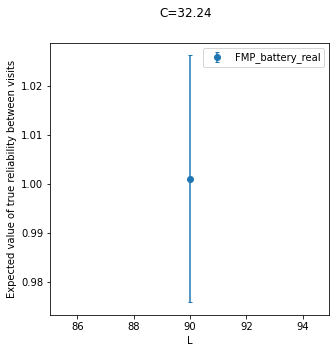

In [10]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True)

for i,task in enumerate(dic_tasks_results.keys()):
    r_xy_array = dic_tasks_results[task][n_trials]['r_xy_array']

#     ax.scatter(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0))
    ax.errorbar(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0), 
#     ax.errorbar(task, r_xy_array.mean(axis=0), 
                yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2, label=task)

    ax.set_ylabel('Expected value of true reliability between visits')
    ax.set_xlabel('L')

plt.suptitle(f"C={dic_tasks_results[task]['defined_C']:.2f}")
plt.legend(bbox_to_anchor=(1,1))
plt.show()
# axs[1].scatter(n_trials_list_GFMT_orig, r_xy_array.mean(axis=0))
# axs[1].errorbar(n_trials_list_GFMT_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
# axs[1].set_ylabel('Expected value of true reliability between visits')
# axs[1].set_xlabel('L')


In [11]:
# fig, axs = plt.subplots(1,2, figsize=(9,5), sharey=True)

# for task,ax in zip(dic_tasks_results.keys(), axs.flatten()):
#     r_xy_array = dic_tasks_results[task][n_trials]['r_xy_array']

#     ax.scatter(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0))
#     ax.errorbar(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0), 
#                 yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)

#     ax.set_ylabel('Expected value of true reliability between visits')
#     ax.set_xlabel('L')

#     ax.set_title(f"{task}, C={dic_tasks_results[task]['defined_C']:.2f}")
# plt.show()
# # axs[1].scatter(n_trials_list_GFMT_orig, r_xy_array.mean(axis=0))
# # axs[1].errorbar(n_trials_list_GFMT_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
# # axs[1].set_ylabel('Expected value of true reliability between visits')
# # axs[1].set_xlabel('L')


#### Combine the dictionaries
[top](#top)

In [12]:
# make a copy
dic_tasks_results_backup = dic_tasks_results

# load the saved dict with reliability errors
with open(os.path.join(path_results, 'simulated_reliability_range_largestL_nsim_1000.pkl'), 'rb') as f:
    dic_reliability_error = pickle.load(f)
    

print(dic_reliability_error.keys())
dic_reliability_error

dict_keys(['FMP_longitudinal_1d_synthetic', 'FMP_longitudinal_1d_real', 'FMP_longitudinal_2d_synthetic', 'FMP_longitudinal_2d_real', 'FMP_longitudinal_3d_synthetic', 'FMP_longitudinal_3d_real'])


{'FMP_longitudinal_1d_synthetic': {'original_C': 24.23783939774275,
  'defined_C': 24.118919698871373,
  256: {'data': array([[0, 1, 1, ..., 0, 0, 1],
          [0, 1, 0, ..., 0, 0, 0],
          [0, 0, 1, ..., 0, 1, 0],
          ...,
          [1, 1, 1, ..., 1, 0, 1],
          [0, 0, 1, ..., 1, 0, 0],
          [1, 0, 0, ..., 1, 0, 1]], dtype=uint8),
   'array_corr_fxn_orig': array([[[0.71799111, 0.72446091, 0.75183189, ..., 0.72330662,
            0.73193903, 0.73302571]],
   
          [[0.78102795, 0.71581481, 0.73616726, ..., 0.73774696,
            0.74129592, 0.7455944 ]],
   
          [[0.75107317, 0.7192747 , 0.7177304 , ..., 0.74740491,
            0.73033875, 0.70729495]],
   
          ...,
   
          [[0.77140676, 0.74320533, 0.78862551, ..., 0.74740208,
            0.76149436, 0.72674804]],
   
          [[0.75420734, 0.7620906 , 0.76165159, ..., 0.75278927,
            0.73020611, 0.70350926]],
   
          [[0.72929245, 0.73393746, 0.723851  , ..., 0.7103814 ,
  

In [13]:
# save this dic to it
for key in dic_tasks_results.keys():
    dic_reliability_error[key] = dic_tasks_results[key]

In [14]:
# save
with open(os.path.join(path_results, f'simulated_reliability_range_largestL_nsim_{n_splits}.pkl'), 'wb') as f:
    pickle.dump(dic_reliability_error, f)
        


In [15]:
%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu -iv

Author: Jan Kadlec

Last updated: Wed Dec 20 2023

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 23.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

sys       : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
matplotlib: 3.6.2
pandas    : 1.2.4
numpy     : 1.19.1
seaborn   : 0.11.1



[top](#top)